<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [1]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
import matplotlib.pyplot as plt

In [2]:
from copy import deepcopy

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [3]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

Существует множество наборов грамматических тегов, или тегсетов, например:
* НКРЯ
* Mystem
* UPenn
* OpenCorpora (его использует pymorphy2)
* Universal Dependencies

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На данный момент стандартом является **Universal Dependencies**. Подробнее про проект можно почитать [вот тут](http://universaldependencies.org/), а про теги — [вот тут](http://universaldependencies.org/u/pos/)

In [4]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


Мы имеем массив предложений пар (слово-тег)

In [5]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [6]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [7]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [8]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [9]:
# freq

In [10]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False) # тег - кол-во тега в корпусе
word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


In [11]:
dict(brown_tagged_words)["to"]

'ADP'

In [12]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

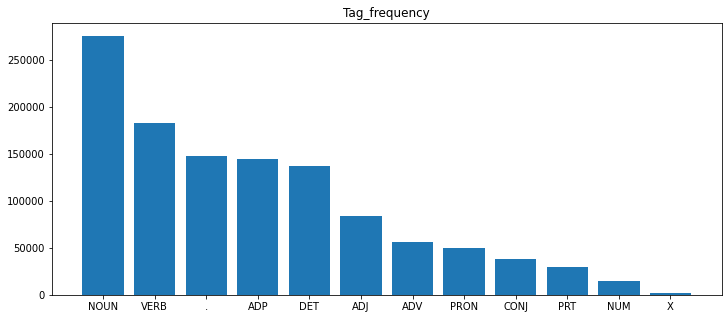

In [13]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [14]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

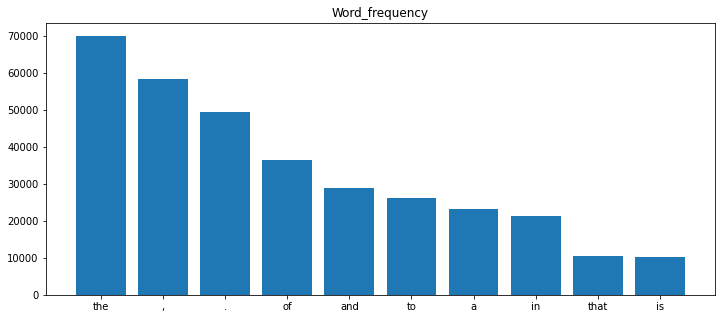

In [15]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?

In [16]:
word_num["cat"]

23

### Вопрос 2:
* Самое популярное слово с самым популярным тегом? <br>(*сначала выбираете слова с самым популярным тегом, а затем выбираете самое популярное слово из уже выбранных*)

In [17]:
# pop_tag = tag_num.index[0]
# pop_tag_words = pd.DataFrame(brown_tagged_words, columns=["word", "tag"]).set_index("tag").loc[pop_tag].copy()
# pd.Series(nltk.FreqDist(pop_tag_words["word"])).idxmax()

In [18]:
pop_tag = tag_num.index[0]
pop_tag_words = [word for (word, tag) in brown_tagged_words if tag == pop_tag]
pd.Series(nltk.FreqDist(pop_tag_words)).idxmax()

'time'

Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [19]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [20]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=0.1, random_state=0,)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [21]:
len(train_sents)

947

In [22]:
len(test_sents)

106

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [7]:
class HiddenMarkovModel:    
    def __init__(self):
        self.default_word = None
        self.tags = None
        self.words = None
        self.A = None
        self.B = None
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word.lower() for sent in train_tokens_tags_list
                 for (word, tag) in sent]
        
        tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False)   #.sort_index()  #'''your code'''
        word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)  #'''your code'''

        # default_word
        pop_tag = tag_num.index[0]
        pop_tag_words = [word.lower() for sent in train_tokens_tags_list 
                         for (word, tag) in sent if tag == pop_tag]
        self.default_word = pd.Series(nltk.FreqDist(pop_tag_words)).idxmax() 
         
        self.tags = tag_num.index
        self.words = word_num.index
        
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) 
                                 for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) 
                                for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)  '''your code'''
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        _test_tokens_list = deepcopy(test_tokens_list)
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(_test_tokens_list))})
        
        for i_sent in range(len(_test_tokens_list)):
            
            current_sent = _test_tokens_list[i_sent] # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                current_sent[t] = current_sent[t].lower()  # применим lower()
                if current_sent[t] not in self.words:
                    current_sent[t] = self.default_word
                    
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    
                    s = self.tags[i_s]
                    
                    # формула (1)
                    q[t + 1][i_s] = np.max(q[t] *                #'''your code'''
                        self.A.loc[:, s] *                        #'''your code'''
                        self.B.loc[current_sent[t], s])
                    
                    # argmax формула(1)
                    
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (q[t] *            #'''your code'''
                                              self.A.loc[:, s] * #'''your code'''
                        self.B.loc[current_sent[t],s]).reset_index()[s].idxmax() # индекс 
                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags                 

Обучите скрытую марковскую модель:

In [24]:
# my_model = ..,
'''your code'''
my_model = HiddenMarkovModel()
my_model.fit(train_sents)

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [25]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
'''your code'''
pred = my_model.predict(sents)
pred

OrderedDict([(0, array(['PRON', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['PRON', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['DET', 'NOUN', 'NOUN'], dtype='<U4'))])

#### Интерпретация:
- модель работает
- результат похож на адекватный
- кое-где ошибается (в том числе, иногда, похоже, на словах, которых нет в словаре. Случай с 'favourite' (см. ниже) - из этой серии, если я правильно определил)

### Вопрос 3:
* Какой тег вы получили для слова `can`?

In [26]:
'''your code'''
test_word = "can"
test_word_tags = [pred[s_num][w_num] for s_num, sent in enumerate(sents) for w_num, word_ in enumerate(sent) if word_ == test_word]
test_word_tags

['VERB']

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?

In [27]:
'''your code'''
test_word = "favourite"
test_word_tags = [pred[s_num][w_num] for s_num, sent in enumerate(sents) for w_num, word_ in enumerate(sent) if word_ == test_word]
test_word_tags

['NOUN']

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [10]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        tags = [tag for (word, tag) in sent] # наши теги
        words = [word.lower() for (word, tag) in sent] # наши слова

        pred = my_model.predict([words])[0]

        true_pred += (np.array(tags) == pred).sum()
        num_pred += len(pred)
    acc = true_pred / num_pred * 100
    print("Accuracy:", acc, '%')
    return acc

In [29]:
%%time
acc = accuracy_score(my_model, test_sents)
acc

Accuracy: 88.82847256549678 %
CPU times: user 34.8 s, sys: 11.1 ms, total: 34.8 s
Wall time: 34.8 s


### Вопрос 5:
* Какое качество вы получили (округлите до одного знака после запятой)?

In [30]:
'''your code'''
print(f"my_model accuracy score = {round(acc, 1)} %")

my_model accuracy score = 88.8 %


## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train (округлите до одного знака после запятой)?

Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения)

In [31]:
train_tags = [tag for sent in train_sents for (word, tag) in sent] # train теги
train_tag_num = pd.Series(nltk.FreqDist(train_tags)).sort_values(ascending=False)
pop_train_tag = train_tag_num.index[0]
pop_train_tag

'NOUN'

In [32]:
from nltk.tag import DefaultTagger
default_tagger = DefaultTagger(pop_train_tag)  # '''your code'''

In [33]:
'''your code'''
def get_accuracy_score(get_preds_fn, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        tags = [tag for (word, tag) in sent] # наши теги
        words = [word.lower() for (word, tag) in sent] # наши слова

        pred = get_preds_fn(words)

        true_pred += (np.array(tags) == pred).sum()
        num_pred += len(pred)
    acc = true_pred / num_pred * 100
    return acc

In [34]:
def get_default_tagger_preds(words):
    return [pair[1] for pair in default_tagger.tag(words)]

In [35]:
default_tagger_acc = get_accuracy_score(get_default_tagger_preds, test_sents)
print(f"default tagger accuracy score = {round(default_tagger_acc, 1)} %")

default tagger accuracy score = 20.2 %


## NLTK, Rnnmorph

Вспомним первый [семинар](https://colab.research.google.com/drive/1FHZVU6yJT61J8w1hALno0stD4VU36rit?usp=sharing) нашего курса. В том семинаре мы с вами работали c некоторыми библиотеками.

Не забудьте преобразовать систему тэгов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [36]:
from nltk.tag.mapping import map_tag

In [37]:
import nltk
nltk.download('averaged_perceptron_tagger')
# nltk.pos_tag(..., tagset='universal')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [38]:
def get_nltk_preds(words):
    return [tag for (word, tag) in nltk.pos_tag(words, tagset='universal')]

In [39]:
! pip install rnnmorph

     |████████████████████████████████| 10.5MB 7.0MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 8.2MB 16.0MB/s 
  Created wheel for rnnmorph: filename=rnnmorph-0.4.0-cp37-none-any.whl size=10521037 sha256=d815d7e6994094359d1313ef5b684217f5f93599fe86ae3c75e8d73e973c80c0
  Stored in directory: /root/.cache/pip/wheels/61/74/5d/3c6c523a759b67e6a81677e2aad003321536587d1575a4face
  Created wheel for russian-tagsets: filename=russian_tagsets-0.6-cp37-none-any.whl size=24635 sha256=e161c4eabc6a017e9d0dc2b58c1083cbc0ab3ac3379119f970a9b32cbfbfd420
  Stored in directory: /root/.cache/pip/wheels/e8/9d/dd/4679aca4031fdb0d3ad65e165ba5343e61441ed7ad587a08e6
Successfully built rnnmorph russian-tagsets


In [40]:
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="en")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [41]:
# rnnmorph example
predictor.predict(sents[0])

[<normal_form=He; word=He; pos=PRON; tag=Case=Nom|Gender=Masc|Number=Sing|Person=3|PronType=Prs; score=1.0000>,
 <normal_form=can; word=can; pos=AUX; tag=VerbForm=Fin; score=1.0000>,
 <normal_form=stay; word=stay; pos=VERB; tag=VerbForm=Inf; score=0.9998>]

In [42]:
def get_rnnmorph_preds(words):
    return [item.pos for item in predictor.predict(words)]

### Вопрос 7:
* Какое качество вы получили, используя каждую из двух библиотек? Сравните их результаты.

* Качество с библиотекой rnnmorph должно быть хуже, так как там используется немного другая система тэгов. Какие здесь отличия?

In [44]:
%%time
# '''your code'''
nltk_acc = get_accuracy_score(get_nltk_preds, test_sents)
print(f"nltk accuracy score = {round(nltk_acc, 1)} %\n\n")

nltk accuracy score = 89.2 %


CPU times: user 79 ms, sys: 1.98 ms, total: 81 ms
Wall time: 80.7 ms


In [45]:
%%time
rnnmorph_acc = get_accuracy_score(get_rnnmorph_preds, test_sents)
print(f"rnnmorph accuracy score = {round(rnnmorph_acc, 1)} %\n\n")

rnnmorph accuracy score = 62.8 %


CPU times: user 7.25 s, sys: 217 ms, total: 7.46 s
Wall time: 7.28 s


#### **Вывод:**
- качество с библиотекой rnnmorph получилось действительно хуже  
- rnnmorph считает значительно дольше

#### Совпадения и отличия систем тегов

In [46]:
universal_tags = set(tag_num.index)

In [47]:
rnnmorph_tags = set()
for sent in train_sents:
    words = [word.lower() for (word, tag) in sent] # наши слова
    rnnmorph_tags = rnnmorph_tags | set(get_rnnmorph_preds(words))

Совпадения:

In [48]:
list(rnnmorph_tags & universal_tags)

['NUM', 'ADV', 'DET', 'X', 'PRON', 'ADP', 'ADJ', 'VERB', 'NOUN']

Отличия:

In [49]:
list(rnnmorph_tags - universal_tags)

['PROPN', 'PUNCT', 'AUX', 'PART', 'SYM', 'CCONJ', 'SCONJ', 'INTJ']

In [50]:
list(universal_tags - rnnmorph_tags)

['PRT', 'CONJ', '.']

## HiddenMarkov на **полной** выборке

In [12]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=0.1, random_state=0,)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [14]:
%%time
my_model = HiddenMarkovModel()
my_model.fit(train_sents)

CPU times: user 4min 42s, sys: 4.05 s, total: 4min 46s
Wall time: 4min 38s


In [15]:
acc = accuracy_score(my_model, test_sents)
print(f"my_model accuracy score = {round(acc, 1)} %")

Accuracy: 96.26470820500671 %
my_model accuracy score = 96.3 %


## BiLSTMTagger

### Подготовка данных

In [16]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories="humor")

Изменим структуру данных

In [17]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('It', 'was', 'among', 'these', 'that', 'Hinkle', 'identified', 'a', 'photograph', 'of', 'Barco', '!', '!'), ('PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.')]


До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [18]:
from torchtext.legacy.data import Field, BucketIterator
import torchtext

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

Вот один наш пример:

In [19]:
print(vars(examples[0]))

{'words': ['it', 'was', 'among', 'these', 'that', 'hinkle', 'identified', 'a', 'photograph', 'of', 'barco', '!', '!'], 'tags': ['PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.']}


Теперь формируем наш датасет

In [20]:
# кладем примеры в наш датасет
dataset = torchtext.legacy.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])  # '''your code'''

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 842
Number of validation examples: 106
Number of testing examples: 105


Построим словари. Параметр `min_freq` выберете сами. При построении словаря испольузем только **train**

In [21]:
WORD.build_vocab(train_data, min_freq=10)  # '''your code''''''your code'''
TAG.build_vocab(train_data, min_freq=10)  # '''your code'''

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 182
Unique tokens in target (en) vocabulary: 13
['<unk>']
['<pad>', 'NOUN', 'VERB', '.', 'DET', 'ADP', 'PRON', 'ADJ', 'ADV', 'CONJ', 'PRT', 'NUM', 'X']


In [22]:
print(vars(train_data.examples[9]))

{'words': ['whosoever', 'violates', 'our', 'rooftree', ',', 'the', 'legend', 'states', ',', 'can', 'expect', 'maximal', 'sorrow', '.'], 'tags': ['PRON', 'VERB', 'DET', 'NOUN', '.', 'DET', 'NOUN', 'VERB', '.', 'VERB', 'VERB', 'ADJ', 'NOUN', '.']}


Посмотрим с насколько большими предложениями мы имеем дело

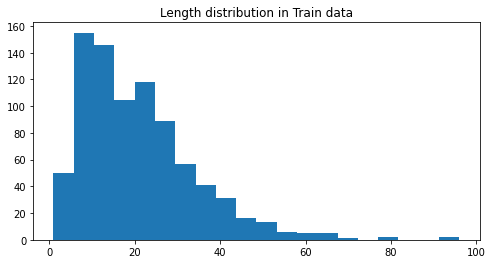

In [23]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

In [24]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [25]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [26]:
# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[27, 4, 4]

### Модель и её обучение

Инициализируем нашу модель

In [56]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False):
        super().__init__()
        
  
        self.embeddings = nn.Embedding(input_dim, emb_dim)   # '''your code'''
        self.dropout = nn.Dropout(p=dropout)    # '''your code'''
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=False, bidirectional=bidirectional)   # '''your code'''
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        # не забываем применить dropout к embedding
        embedded = self.dropout(self.embeddings(sent))   # '''your code'''

        output, _ = self.rnn(embedded)    # '''your code'''
        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output.reshape(-1, output.shape[-1]))  # '''your code'''
    
        return prediction
        
# параметры модели
INPUT_DIM = len(WORD.vocab)  # '''your code'''
OUTPUT_DIM = len(TAG.vocab)  # '''your code'''
EMB_DIM = 1000   # '''your code'''
HID_DIM = 500  # '''your code'''
DROPOUT = 0.2   # '''your code'''
BIDIRECTIONAL = True   # '''your code'''

model = LSTMTagger(input_dim=INPUT_DIM, emb_dim=EMB_DIM, hid_dim=HID_DIM, 
                   output_dim=OUTPUT_DIM, dropout=DROPOUT, bidirectional=BIDIRECTIONAL).to(device)   # '''your code'''

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(182, 1000)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn): LSTM(1000, 500, bidirectional=True)
  (tag): Linear(in_features=1000, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [57]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())   # '''your code'''

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,203,013 trainable parameters


Погнали обучать

In [58]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        #'''your code'''
        optimizer.zero_grad()
        words = batch.words.to(device)
        tags = batch.tags.to(device)
        
        output = model(words)   # '''your code'''    
        
        #tags = [sent len, batch size]
        #output = [sent len, batch size, output dim]
        
        output = output.view(-1, output.shape[-1])   # '''your code'''
        tags = tags.view(-1)
        
        #tags = [sent len * batch size]
        #output = [sent len * batch size, output dim]
        
        loss = criterion(output, tags)   # '''your code'''
        
        loss.backward()
        
        # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            '''your code'''
            words = batch.words.to(device)
            tags = batch.tags.to(device)

            output = model(words)   # '''your code'''

            #tags = [sent len, batch size]
            #output = [sent len, batch size, output dim]

            output = output.view(-1, output.shape[-1])   # '''your code'''
            tags = tags.view(-1)

            #tags = [sent len * batch size]
            #output = [sent len * batch size, output dim]

            loss = criterion(output, tags)   # '''your code'''
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

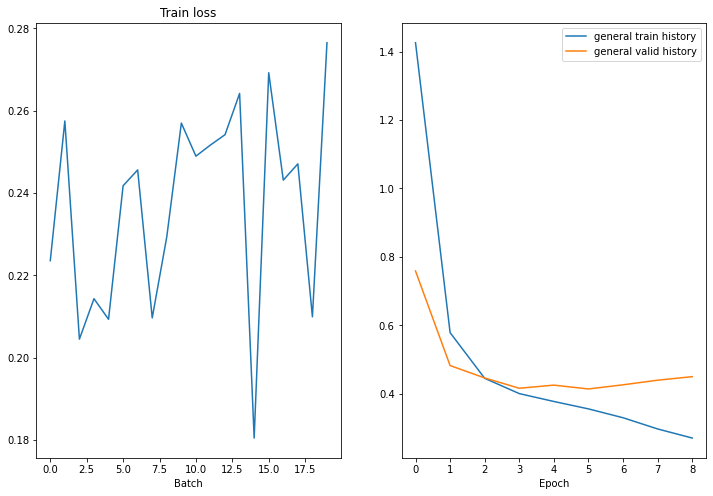

Epoch: 10 | Time: 0m 1s
	Train Loss: 0.240 | Train PPL:   1.271
	 Val. Loss: 0.472 |  Val. PPL:   1.604


In [59]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 10   # '''your code'''
CLIP = 2   # '''your code'''

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Применение модели

In [60]:
def accuracy_model(model, iterator):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            # '''your code'''
            words = batch.words.to(device)
            tags = batch.tags.to(device)

            #output = [sent len, batch size, output dim]
            output = model(words)  #'''your code''
            
            output = torch.argmax(output.reshape(-1, output.shape[-1]), 
                                  dim=1).reshape(tags.shape)
            
            #output = [sent len, batch size]
            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
        
    return round(true_pred / num_pred * 100, 3)

In [61]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 85.157 %


In [62]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
print(f"Accuracy: {accuracy_model(best_model, test_iterator):.1f} % (best_model)")
# assert accuracy_model(best_model, test_iterator) >= 93

Accuracy: 84.9 % (best_model)


Вы можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, вам неообходимо взять все выборку, а не только категорию `humor`.

## LstmTagger на **полной** выборке

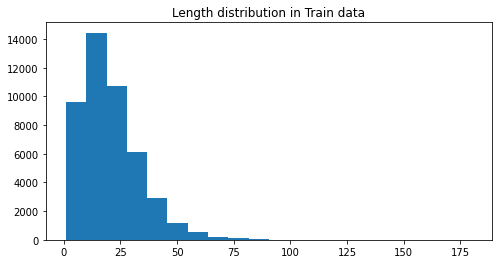

In [71]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

# кладем примеры в наш датасет
dataset = torchtext.legacy.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])  # '''your code'''

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

WORD.build_vocab(train_data, min_freq=10)  # '''your code''''''your code'''
TAG.build_vocab(train_data, min_freq=10)  # '''your code'''

# Length distribution in Train data
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

In [72]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[1434, 180, 180]

In [73]:
# параметры модели
INPUT_DIM = len(WORD.vocab)  # '''your code'''
OUTPUT_DIM = len(TAG.vocab)  # '''your code'''
EMB_DIM = 1000   # '''your code'''
HID_DIM = 500  # '''your code'''
DROPOUT = 0.2   # '''your code'''
BIDIRECTIONAL = True   # '''your code'''

model = LSTMTagger(input_dim=INPUT_DIM, emb_dim=EMB_DIM, hid_dim=HID_DIM, 
                   output_dim=OUTPUT_DIM, dropout=DROPOUT, bidirectional=BIDIRECTIONAL).to(device)   # '''your code'''

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,296,013 trainable parameters


In [74]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

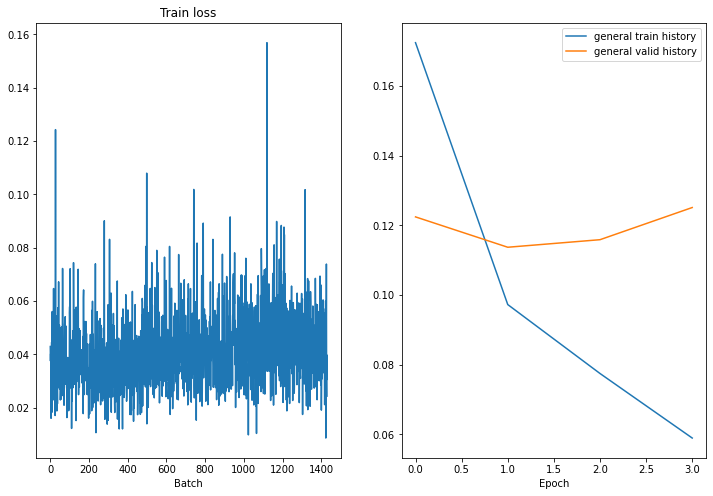

Epoch: 05 | Time: 1m 7s
	Train Loss: 0.041 | Train PPL:   1.041
	 Val. Loss: 0.141 |  Val. PPL:   1.151


In [75]:
train_history = []
valid_history = []

N_EPOCHS = 5   # '''your code'''
CLIP = 2   # '''your code'''

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [76]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 96.186 %


Вам неоходимо добиться качества не меньше, чем `accuracy = 93 %` 

In [77]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
print(f"Accuracy: {accuracy_model(best_model, test_iterator):.1f} % (best_model)")
assert accuracy_model(best_model, test_iterator) >= 93

Accuracy: 96.3 % (best_model)


Пример решение нашей задачи:

In [78]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [79]:
print_tags(model, pos_data[-1])

From           VERB
what           DET
I              NOUN
was            VERB
able           ADJ
to             ADP
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  ADJ
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


## Сравните результаты моделей HiddenMarkov, LstmTagger:
* при обучение на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе

In [84]:
# соберем вместе результаты тестов
print("Accuracy:")
pd.DataFrame(
    {
        "HiddenMarkov": [88.8, 96.3], 
        "LstmTagger": [85.2, 96.3]
    }, index=["humor", "full"]
)

Accuracy:


,HiddenMarkov,LstmTagger
humor,88.8,85.2
full,96.3,96.3


#### Резюме:
На этих тестах на полной выборке результаты практически идентичны, на части корпуса, на категории `humor` методика **HiddenMarkov** сработала немного лучше 